In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 

from traffic.core import Traffic

/tmp/ipykernel_1904265/251887701.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


- Configuration est :  atterrissages 06 / décollages 07 -> A privilégier pour voir des interactions nb: 7818/7616
- Configuration ouest : atterrissages 25 / décollages 24 nb : 9346/9250

# Landings on Runway 06 FAF D8.4 ORE / landings on Runway 25

In [2]:
t1 = Traffic.from_file("../deep_traffic_generation/data/landings/LFPO_dataset.parquet.gz")

In [3]:
ld_LFPO = list()

for f in tqdm(t1):
    if landings := f.aligned_on_ils("LFPO").next():
        ld_LFPO.append(
            {
                "callsign": f.callsign,
                "icao24": f.icao24,
                "flight_id": f.flight_id,
                "airport": "LFPO",
                "stop": landings.stop,
                "ILS": landings.ILS_max, #shortcut
            })

landings_LFPO = pd.DataFrame.from_records(ld_LFPO)

  0%|          | 0/17348 [00:00<?, ?it/s]

In [4]:
landings_LFPO.ILS.value_counts()

25    9346
06    7818
24     102
07      47
02      33
20       1
Name: ILS, dtype: int64

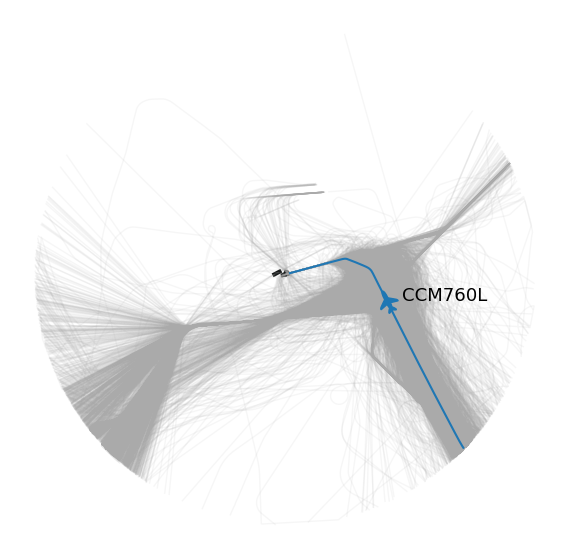

In [5]:
from traffic.core.projection import Lambert93
from traffic.data import airports
from traffic.data import navaids

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    idx = landings_LFPO.query("ILS == '25'").flight_id.tolist()

    t1[idx].plot(ax, alpha=0.1)

    k = 2000
    t1[idx][k].plot(ax, color="#1f77b4", lw=1.5)
    t1[idx][k].at_ratio(0.5).plot(
        ax,
        color="#1f77b4",
        zorder=3,
    )

    airports["LFPO"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

plt.show()

Output()

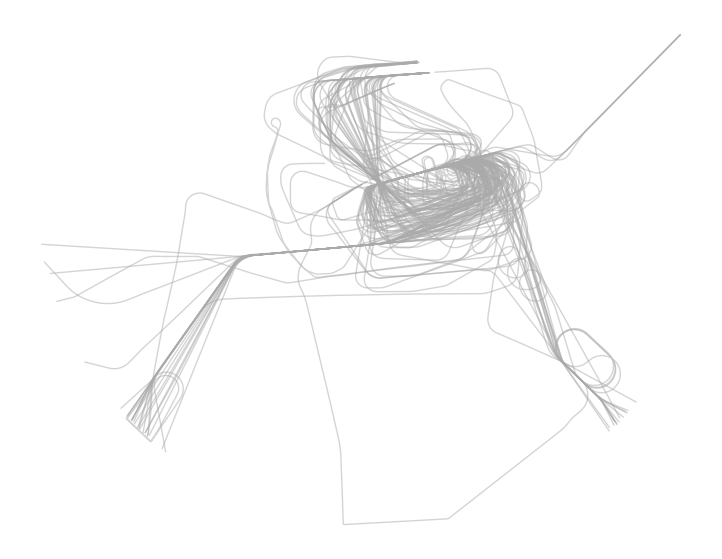

In [6]:
#Identify trajectories that have an ascent phase
t_ld = t1[idx]
t_ld_phases = t_ld.iterate_lazy().phases().eval(desc = "", max_workers = 20)
id_climb = t_ld_phases.query("phase ==  'CLIMB'").flight_ids

with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_ld[id_climb].plot(ax, alpha=0.5)
plt.show()

t_ld = t_ld.query(
    f"flight_id not in {id_climb}"
)

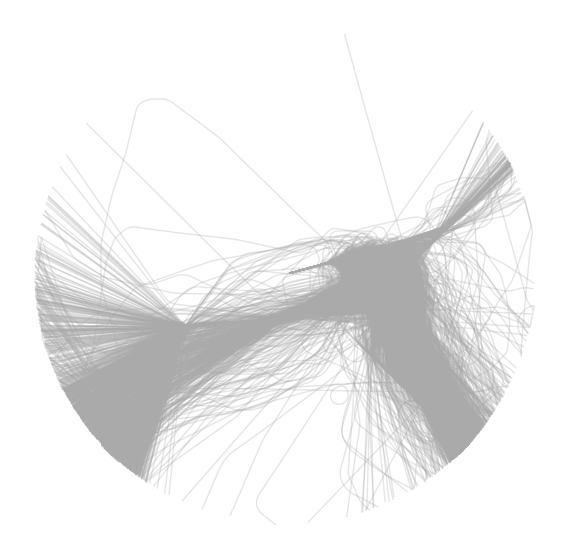

In [7]:
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_ld.plot(ax, alpha=0.3)
plt.show()

In [8]:
#For runway 25
altitudes = {}
for f in tqdm(t_ld):
    altitudes[f.flight_id] = f.at().altitude

altitudes = dict(sorted(altitudes.items(), key=lambda item: item[1], reverse=True))

t_ld = t_ld.query("flight_id not in ['TAR718_819', 'TVF22DP_12899']")

  0%|          | 0/9237 [00:00<?, ?it/s]

In [9]:
# Selecting from south-west only, without loops
def simple(flight):
    return flight.assign(simple=lambda x: flight.shape.is_simple)

first_track = t_ld.data.groupby("flight_id")["track"].first()
id_from_south = first_track[(first_track > 15) & (first_track < 150)].index
t_ld = t_ld[id_from_south]

t_ld = t_ld.iterate_lazy().pipe(simple).eval(desc ="")
t_ld = t_ld.query("simple")

Output()

In [10]:
#Cut every trajectories 1NM before runway threshold

from traffic.core.mixins import PointMixin

thres = PointMixin()
thres.latitude, thres.longitude =  (airports["LFPO"].runways.data.query("name == '25'").latitude.values[0], airports["LFPO"].runways.data.query("name == '25'").longitude.values[0])


def til_thres(flight):
    g = flight.query("distance > 1*1.852")
    if g is None:
        return None
    return flight.before(g.stop)


t_ld = t_ld.distance(thres).pipe(til_thres).eval()

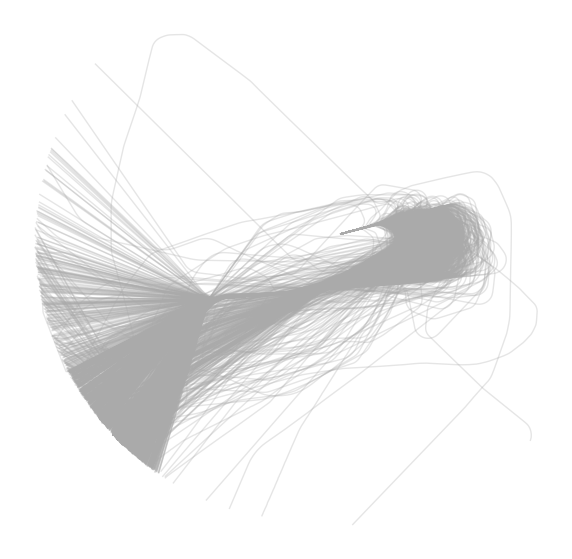

In [12]:
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_ld.plot(ax, alpha=0.3)
plt.show()

In [13]:
# Warning. we can have early go-arounds, especially for 25

t_ld = t_ld.iterate_lazy().resample(200).eval(desc = "", max_workers = 20)
# t_ld.to_parquet("../deep_traffic_generation/data/training_datasets/landings_06.parquet.gz")
# t_ld.to_parquet("../deep_traffic_generation/data/landings/landings_25.parquet.gz")
t_ld.to_parquet("../deep_traffic_generation/data/landings/landings_south_25.parquet.gz")

Output()

# Takeoffs

In [14]:
t2 = Traffic.from_file("../deep_traffic_generation/data/takeoffs/LFPO_dataset.parquet.gz")
t2 = t2.query("flight_id not in ['CALIBRA_9925', 'CALIBRA_9927', 'CALIBRA_9926']")
t2 = t2.resample("1s").eval(desc = "", max_workers = 20)

Output()

In [15]:
to_LFPO = list()

for f in tqdm(t2):
    if takeoff := f.takeoff_from_runway("LFPO").next():
        to_LFPO.append(
            {
                "callsign": f.callsign,
                "icao24": f.icao24,
                "flight_id": f.flight_id,
                "airport": "LFPO",
                "start": takeoff.start,
                "RWY": takeoff.runway_max, #shortcut
            })

takeoffs_LFPO = pd.DataFrame.from_records(to_LFPO)

  0%|          | 0/17106 [00:00<?, ?it/s]

In [17]:
takeoffs_LFPO.RWY.value_counts()

24    9258
07    7625
06     150
25      53
20       2
02       1
Name: RWY, dtype: int64

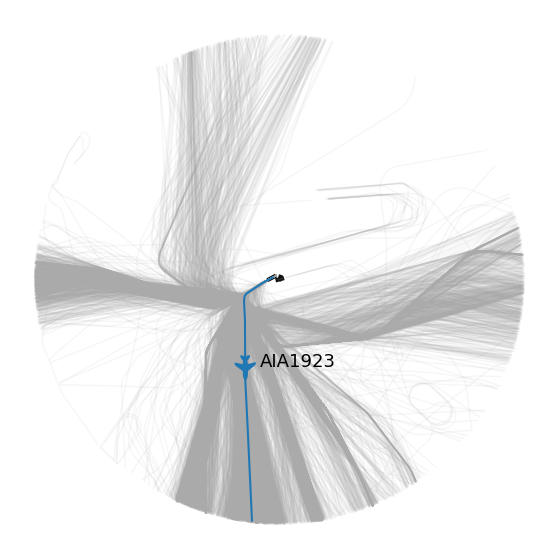

In [34]:
from traffic.core.projection import Lambert93
from traffic.data import airports
from traffic.data import navaids

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    idx = takeoffs_LFPO.query("RWY == '24'").flight_id.tolist()

    t2[idx].plot(ax, alpha=0.1)

    k = 2000
    t2[idx][k].plot(ax, color="#1f77b4", lw=1.5)
    t2[idx][k].at_ratio(0.5).plot(
        ax,
        color="#1f77b4",
        zorder=3,
    )

    airports["LFPO"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

plt.show()

Output()

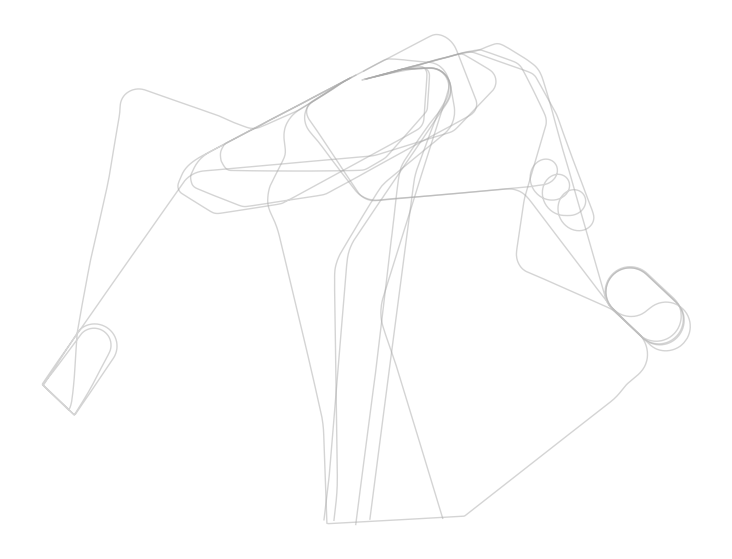

In [42]:
#suppress aircrafts that land back in LFPO
t_to = t2

ga = t_to.iterate_lazy().has(f"aligned_on_LFPO").eval(desc = "", max_workers = 20)
t_to = t_to.query(
    f"flight_id not in {ga.flight_ids}"
)

with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    ga.plot(ax, alpha=0.5)
plt.show()

Output()

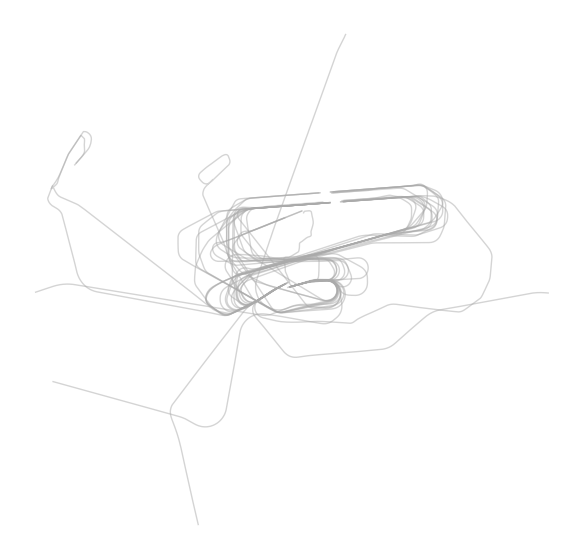

In [43]:
#Identify trajectories that land on an other airport (mostly le Bourget)
t_to_phases = t_to.iterate_lazy().phases().eval(desc = "", max_workers = 20)
id_descent = t_to_phases.query("phase ==  'DESCENT'").flight_ids

with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_to[id_descent].plot(ax, alpha=0.5)
plt.show()

t_to = t_to.query(
    f"flight_id not in {id_descent}"
)

In [44]:
def simple(flight):
    return flight.assign(simple=lambda x: flight.shape.is_simple)

last_track = t_to.data.groupby("flight_id")["track"].last()
id_to_south = last_track[(last_track > 45) & (last_track < 210)].index
t_to = t_to[id_to_south]

t_to = t_to.iterate_lazy().pipe(simple).eval(desc ="")
t_to = t_to.query("simple")

Output()

In [45]:
#Takeoff in 07. So we cut every trajectory 1NM after the end of runway (ie the threshold of runway 25)
#Takeoff in 24. So we cut every trajectory 1NM after the end of runway (ie the threshold of runway 06)

from traffic.core.mixins import PointMixin

thres_25 = PointMixin()
thres_25.latitude, thres_25.longitude =  (airports["LFPO"].runways.data.query("name == '25'").latitude.values[0], airports["LFPO"].runways.data.query("name == '25'").longitude.values[0])


def til_thres(flight):
    g = flight.query("distance > 2*1.852")
    if g is None:
        return None
    return flight.after(g.start)


t_to = t_to[idx].distance(thres_25).pipe(til_thres).eval(desc = "")

Output()

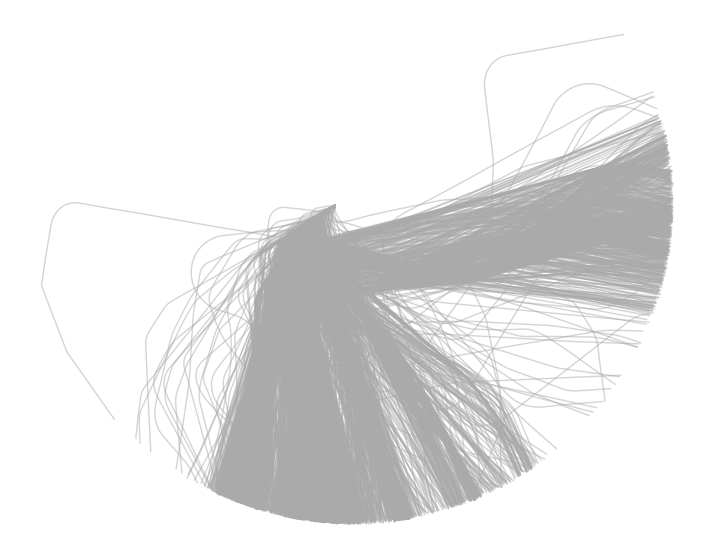

In [46]:
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_to.plot(ax, alpha=0.5)
plt.show()

/tmp/ipykernel_141555/2002292500.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  latlon = t_to.data.groupby(by="flight_id")["latitude", "longitude"].first()


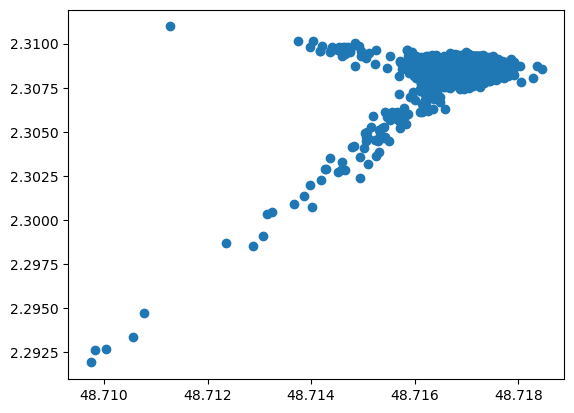

In [47]:
latlon = t_to.data.groupby(by="flight_id")["latitude", "longitude"].first()
plt.scatter(latlon.latitude, latlon.longitude)
plt.show()

In [48]:
#Suppress trajectories that end at low altitudes + suprious one DAH1007_1056
altitudes = {}
for f in tqdm(t_to):
    altitudes[f.flight_id] = f.at().altitude

altitudes = dict(sorted(altitudes.items(), key=lambda item: item[1]))

#For takeoffs 07
t_to = t_to.query("flight_id not in ['DAH1007_1056', 'AFR72KT_6220', 'AFR841_5603']")

  0%|          | 0/7383 [00:00<?, ?it/s]

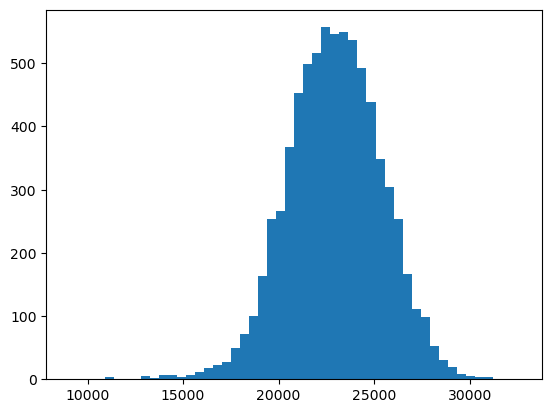

In [55]:
lists = altitudes.items()
x,y = zip(*lists) # unpack a list of pairs into two tuples

plt.hist(y, bins = 50)
plt.show()

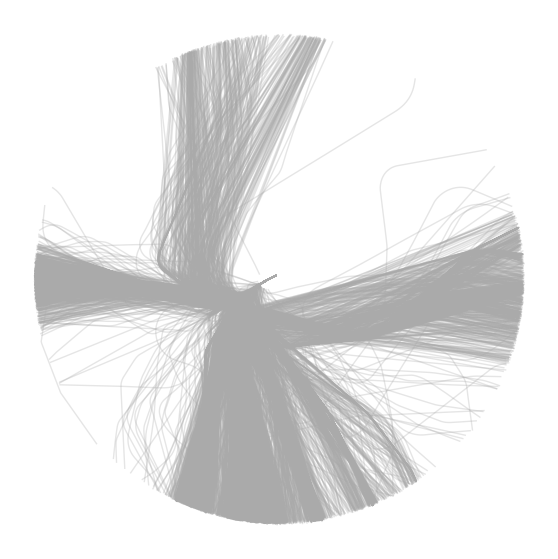

In [50]:
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_to.plot(ax, alpha=0.3)
    
    k =  np.random.randint(len(t_to))
    t_to[k].plot(ax, color="#1f77b4", lw=1.5)
    t_to[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

plt.show()

In [56]:
t_to = t_to.iterate_lazy().resample(200).eval(desc = "", max_workers = 20)
# t_to.to_parquet("../deep_traffic_generation/data/training_datasets/takeoffs_07.parquet.gz")
# t_to.to_parquet("../deep_traffic_generation/data/takeoffs/takeoffs_24.parquet.gz")
t_to.to_parquet("../deep_traffic_generation/data/takeoffs/takeoffs_south_24.parquet.gz")

Output()

# Cut takeoffs from 24 that doesn't respect the procedure

Should be under FL100 at (Every takeoffs, even the one that goes to east):
- PO300: (48.4938611, 2.3675277777777777)
- PO301: (48.4786667, 2.316)
- PO303: (48.47325, 2.0965)
- PO271: (48.4815, 2.00867)

In [3]:
t_test = Traffic.from_file("../deep_traffic_generation/data/training_datasets/takeoffs_south_proc_LFPO_24.pkl")

In [6]:
test = t_test.inside_bbox((2.367527-0.001, 48.4938611-0.001, 2.367527+0.001, 48.4938611+0.001))

(array([ 5.,  6.,  5., 14., 24., 15., 18.,  5.,  7.,  5.]),
 array([ 8500.,  8845.,  9190.,  9535.,  9880., 10225., 10570., 10915.,
        11260., 11605., 11950.]),
 <BarContainer object of 10 artists>)

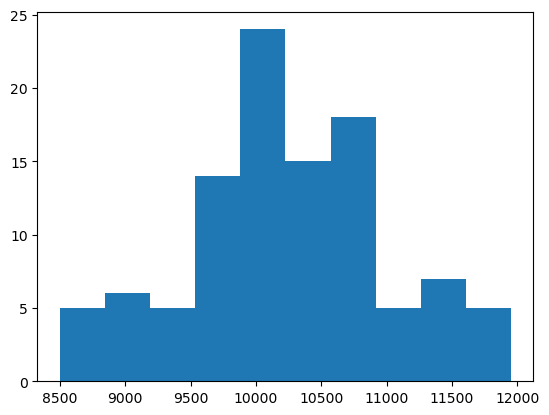

In [7]:
plt.hist(test.data.altitude)

In [4]:
t = Traffic.from_file("../deep_traffic_generation/data/training_datasets/takeoffs_south_LFPO_24.pkl")

In [9]:
t[:1000].map_leaflet()

Map(center=[48.3953264874153, 2.2930871053072575], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [35]:
t = t.resample("1s").eval(desc = "", max_workers=50)

Output()

In [ ]:
from ipyleaflet import Map, basemaps, Marker, MarkerCluster, Polygon, AwesomeIcon
from ipywidgets import Layout
from traffic.data import airports

map_ = Map(
    center=airports["LFPO"].latlon,
    zoom=10,
    basemap=basemaps.Stamen.Terrain,
    layout=Layout(width="100%", height="1000px"),
)

marker1 = Marker(location=(48.4938611, 2.367528), draggable=False)
map_.add_layer(marker1)

marker2 = Marker(location=(48.4786667, 2.316), draggable=False)
map_.add_layer(marker2)

marker3 = Marker(location=(48.47325, 2.0965), draggable=False)
map_.add_layer(marker3)

marker4 = Marker(location=(48.4815, 2.00867), draggable=False)
map_.add_layer(marker4)

polygon1 = Polygon(
    locations=[(48.4938611 + 0.001, 2.367528 - 0.025), (48.4938611 - 0.02, 2.367528 - 0.025), (48.4938611 - 0.02, 2.367528 + 0.2), (48.4938611 + 0.001, 2.367528 + 0.2)],
    color="#4c78a8",
    fill_color="#4c78a8"
)
map_.add_layer(polygon1)

polygon2 = Polygon(
    locations=[(48.4786667+0.001, 2.316-0.11), (48.4786667-0.02, 2.316-0.11), (48.4786667-0.02, 2.316+0.025), (48.4786667+0.001, 2.316+0.025)],
    color="#4c78a8",
    fill_color="#4c78a8"
)
map_.add_layer(polygon2)

polygon3 = Polygon(
    locations=[(48.47325+0.001, 2.0965-0.043), (48.47325-0.02, 2.0965-0.043), (48.47325-0.02, 2.0965+0.11), (48.47325+0.001, 2.0965+0.11)],
    color="#4c78a8",
    fill_color="#4c78a8"
)
map_.add_layer(polygon3)

polygon4 = Polygon(
    locations=[(48.4815+0.001, 2.00867-0.1), (48.4815-0.02, 2.00867-0.1), (48.4815-0.02, 2.00867+0.043), (48.4815+0.001, 2.00867+0.043)],
    color="#4c78a8",
    fill_color="#4c78a8"
)
map_.add_layer(polygon4)

polygon5 = Polygon(
    locations=[(48.52, 1.8), (48.47, 1.8), (48.47, 2.6), (48.52, 2.6)],
    color="#4c78a8",
    fill_color="#4c78a8"
)
map_.add_layer(polygon5)


map_

In [12]:
test = t.inside_bbox((1.8, 48.47, 2.6, 48.55))
alt = test.data.groupby("flight_id")["altitude"].first()
alt_id = alt[alt < 9500].index
t_test = t[alt_id]
t_test.to_pickle("../deep_traffic_generation/data/training_datasets/takeoffs_south_procV4_LFPO_24.pkl")


In [36]:
bbox1 = (2.367528 - 0.025, 48.4938611 - 0.02, 2.367528 + 0.2, 48.4938611 + 0.001)
bbox2 = (2.316-0.11, 48.4786667-0.02, 2.316+0.025, 48.4786667+0.001)
bbox3 = (2.0965-0.043, 48.47325-0.02, 2.0965+0.11, 48.47325+0.001)
bbox4 = (2.00867-0.1, 48.4815-0.02, 2.00867+0.043, 48.4815+0.001)

In [37]:
t_bbox1 = t.inside_bbox(bbox1)
t_bbox2 = t.inside_bbox(bbox2)
t_bbox3 = t.inside_bbox(bbox3)
t_bbox4 = t.inside_bbox(bbox4)

In [38]:
alt1 = t_bbox1.data.groupby("flight_id")["altitude"].first()
alt_id1 = alt1[alt1 < 10000].index

alt2 = t_bbox2.data.groupby("flight_id")["altitude"].first()
alt_id2 = alt2[alt2 < 10000].index

alt3 = t_bbox3.data.groupby("flight_id")["altitude"].first()
alt_id3 = alt3[alt3 < 10000].index

alt4 = t_bbox4.data.groupby("flight_id")["altitude"].first()
alt_id4 = alt4[alt4 < 10000].index


In [42]:
final_id = alt_id1.to_list() + alt_id2.to_list() + alt_id3.to_list() + alt_id4.to_list()

In [45]:
t_proc = t[final_id]
t_proc

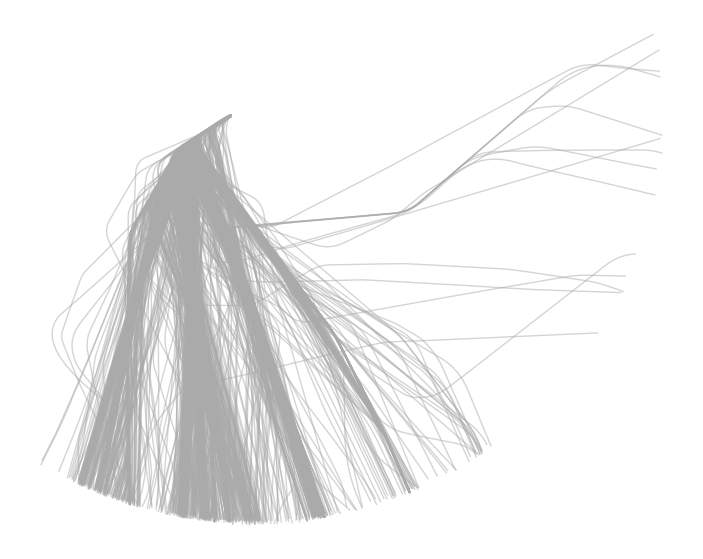

In [47]:
from traffic.core.projection import Lambert93
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_proc.plot(ax, alpha=0.5)
plt.show()

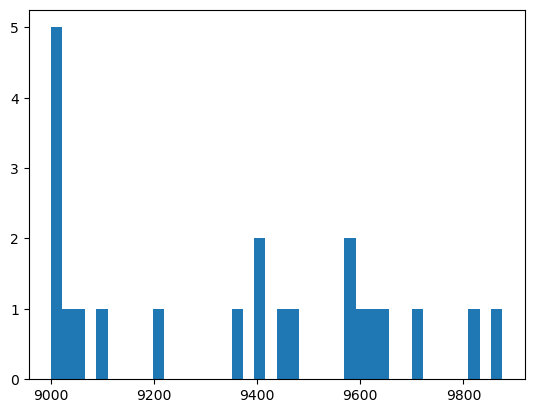

In [57]:
# 48.47325, 2.0965
test = t_proc.inside_bbox((2.0965-0.001, 48.47325-0.001, 2.0965+0.001, 48.47325+0.001))
plt.hist(test.data.altitude, bins = 40)
plt.show()

In [49]:
t_proc = t_proc.resample(200).eval(desc = "", max_workers = 10)

Output()

In [50]:
t_proc

,count
flight_id,
AEA37YM_013,200
TVF30UY_4434,200
TVF31KZ_4483,200
TVF31KZ_4482,200
TVF31KZ_4480,200
TVF31JT_4478,200
TVF31JT_4474,200
TVF31JT_4466,200
TVF31EW_4461,200


In [51]:
t_proc.to_pickle("../deep_traffic_generation/data/training_datasets/takeoffs_south_proc_LFPO_24.pkl")

In [54]:
#Test Benoit
from shapely.geometry import LineString
from shapely.ops import nearest_points

line = LineString([
    (1.8, 48.4815),
    (2.00867, 48.4815),
    (2.0965, 48.47325),
    (2.316, 48.4786667),
    (2.3675277777777777, 48.4938611),
    (2.6, 48.4938611)
    ])

# Ici on garde que ce qui passe sur la ligne
t_test = t.intersects(line)

def filter_alt(flight):
    isect = flight.linestring.intersection(line)
    lon,lat = nearest_points(flight.linestring, isect)[0].coords.xy
    lon = lon[0]
    lat = lat[0]
    if flight.data.query("abs(latitude-@lat)<1/200 & abs(longitude-@lon)<1/200").altitude.max()<10000:
        return flight

t_test = t_test.iterate_lazy().pipe(filter_alt).eval(desc='t')

Check the documentation for more options.


Output()

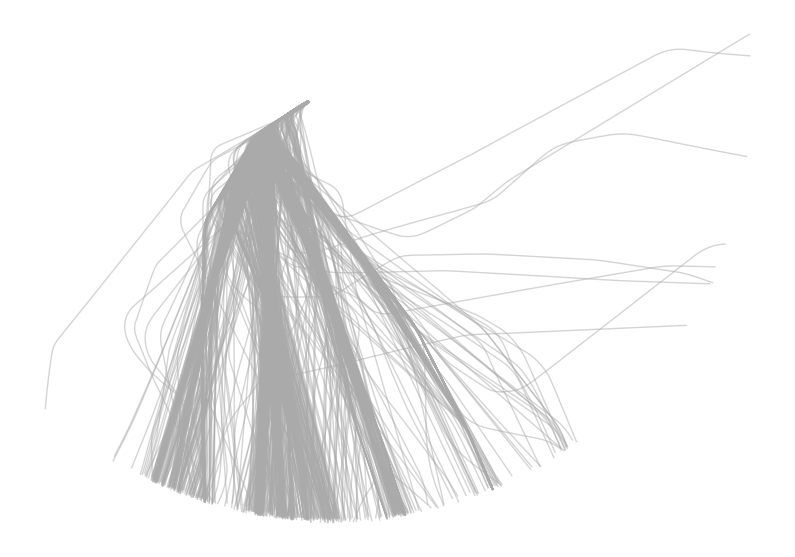

In [58]:
from traffic.core.projection import Lambert93
with plt.style.context("traffic"):
    ax = plt.axes(projection=Lambert93())
    t_test.plot(ax, alpha=0.5)
plt.show()